In [12]:
import sys
from time import time
import math
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import grad
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
torch.set_default_dtype(torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import pandas as pd

cuda


In [13]:
lambda0 = 0.1
Tmax = 1.0 # time [0, 1]
Lx = 1.0 # x [0, 1]

def exact_u(t):
    t = np.array(t, dtype=float)
    num = -2*lambda0*np.exp(2*t)
    den = -2 + 3*lambda0*(1 - np.exp(2*t))
    return (num/den).astype(float)

# sanity check
print("u(0) =", exact_u(0.0))
print("u(0.5) =", exact_u(0.5))


u(0) = 0.1
u(0.5) = 0.21612391378346732


In [14]:
class PINNNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.ModuleList()
        for i in range(len(layers)-1):
            self.net.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()
        # weight init
        for m in self.net:
            # glorot distribution to keep variance across the layers roughly the same
            nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)
    def forward(self, x, t):
        # input concatenation
        X = torch.cat([x, t], dim=-1)
        z = X
        for i,layer in enumerate(self.net[:-1]):
            z = layer(z)
            z = self.activation(z)
        z = self.net[-1](z)
        return z


In [15]:
def sample_collocation(Nf):
    # sample in interior (x,t) uniformly
    x = torch.rand(Nf,1, device=device)*Lx
    t = torch.rand(Nf,1, device=device)*Tmax
    x.requires_grad_(True); t.requires_grad_(True)
    return x, t

def sample_boundary(Nb):
    t = torch.rand(Nb,1, device=device)*Tmax
    x0 = torch.zeros(Nb,1, device=device)
    x1 = torch.ones(Nb,1, device=device)*Lx
    x = torch.cat([x0, x1], dim=0)
    t = torch.cat([t, t], dim=0)
    return x, t

def sample_initial(Ni):
    # initial condition at t=0 for x in [0,1]
    x = torch.rand(Ni,1, device=device)*Lx
    t = torch.zeros_like(x, device=device)
    return x, t

# helper to have tensor targets for BC and IC
def make_target_for_bc_ic(x,t):
    u_values = torch.tensor(exact_u(t.detach().cpu().numpy().reshape(-1,)), device=device).reshape(-1,1)
    return u_values


In [16]:
def pinn_pde_residual(model, x, t):
    # residual = u_t - u_xx - 2u + 3u^2
    u = model(x, t)
    u_t = grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_x = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
    r = u_t - u_xx - 2.0*u + 3.0*u*u
    return r

def loss_all(model, Nf=2000, Nb=200, Ni=200):
    x_f, t_f = sample_collocation(Nf)
    x_b, t_b = sample_boundary(Nb)
    x_i, t_i = sample_initial(Ni)

    # residual loss
    r = pinn_pde_residual(model, x_f, t_f)
    loss_r = torch.mean(r**2)

    # BC and IC losses
    u_b_pred = model(x_b, t_b)
    u_b_true = make_target_for_bc_ic(x_b, t_b)
    loss_b = torch.mean((u_b_pred - u_b_true)**2)

    u_i_pred = model(x_i, t_i)
    u_i_true = torch.full_like(u_i_pred, lambda0, device=device)
    loss_i = torch.mean((u_i_pred - u_i_true)**2)

    return loss_r + loss_b + loss_i, loss_r.detach().cpu().item(), loss_b.detach().cpu().item(), loss_i.detach().cpu().item()


In [17]:

def train_pinn(model, epochs=4000, Nf=2000, Nb=200, Ni=200, lr=1e-3, print_every=200, eps = 1e-5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {"total":[], "res":[], "bc":[], "ic":[]}
    t0 = time()
    for ep in range(epochs):
        optimizer.zero_grad()
        loss, lr_loss, lb_loss, li_loss = loss_all(model, Nf=Nf, Nb=Nb, Ni=Ni)

        loss.backward()
        optimizer.step()
        history["total"].append(loss.item()); history["res"].append(lr_loss)
        history["bc"].append(lb_loss); history["ic"].append(li_loss)
        if (ep+1)%print_every==0 or ep==0:
            print(f"Ep {ep+1}/{epochs}  total={loss.item():.3e}  res={lr_loss:.3e}  bc={lb_loss:.3e}  ic={li_loss:.3e}")
        if loss < eps:
            print(f"Loss reached {loss} at epoch {ep}.")
            break
        
    print("Training time (s):", time()-t0)
    return history

# 4 hidden layers with 64 neurons in each
layers = [2, 64, 64, 64, 64, 1]
model = PINNNet(layers).to(device)


In [18]:
hist = train_pinn(model, epochs=4000, Nf=10000, Nb=800, Ni=800, lr=0.02, print_every=500)


Ep 1/4000  total=7.323e-02  res=4.376e-02  bc=1.048e-02  ic=1.899e-02
Ep 500/4000  total=7.890e-05  res=3.001e-05  bc=3.117e-05  ic=1.772e-05
Ep 1000/4000  total=4.052e-05  res=1.844e-05  bc=1.473e-05  ic=7.354e-06
Ep 1500/4000  total=3.037e-05  res=1.322e-05  bc=1.140e-05  ic=5.747e-06
Ep 2000/4000  total=2.342e-05  res=9.373e-06  bc=9.302e-06  ic=4.741e-06
Ep 2500/4000  total=1.747e-05  res=6.313e-06  bc=7.924e-06  ic=3.232e-06
Ep 3000/4000  total=1.279e-05  res=4.151e-06  bc=6.287e-06  ic=2.350e-06
Loss reached 9.991001043200358e-06 at epoch 3258.
Training time (s): 64.42035174369812


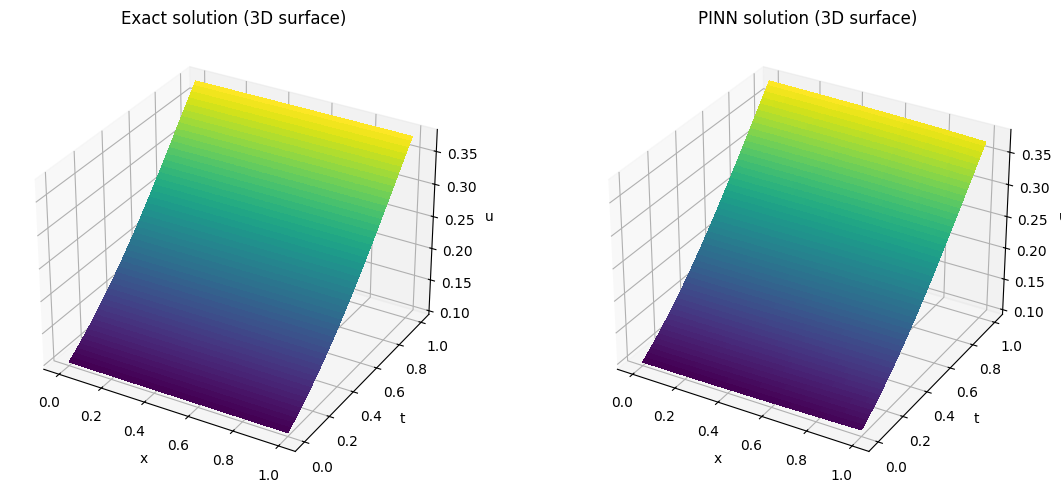

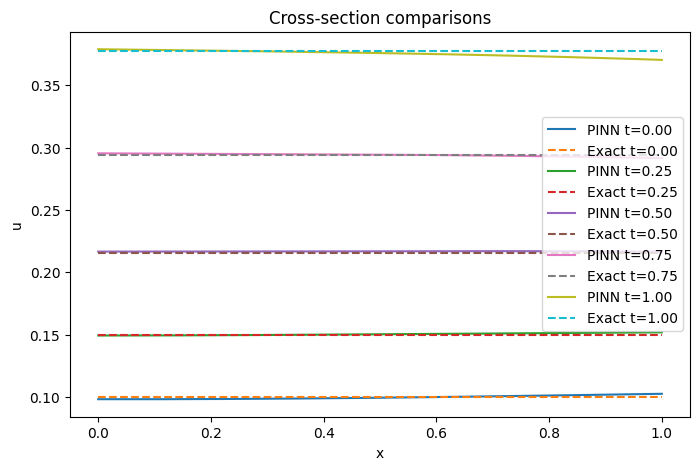

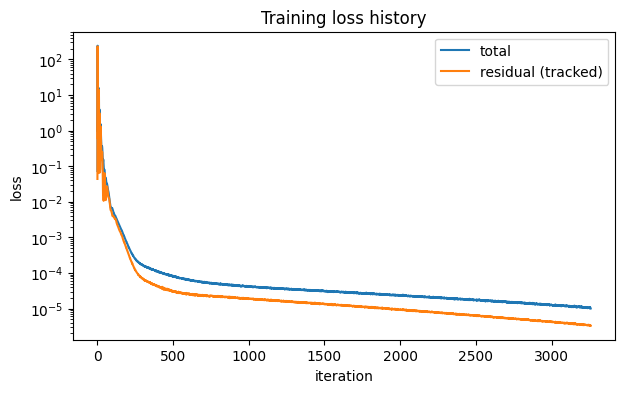

In [19]:
# create grid
nx = 200; nt = 200
xs = np.linspace(0, Lx, nx)
ts = np.linspace(0, Tmax, nt)
Xg, Tg = np.meshgrid(xs, ts)
Xg_flat = torch.tensor(Xg.reshape(-1,1), dtype=torch.float32, device=device)
Tg_flat = torch.tensor(Tg.reshape(-1,1), dtype=torch.float32, device=device)

# model predictions
with torch.no_grad():
    U_pred_flat = model(Xg_flat, Tg_flat).cpu().numpy().reshape(nt, nx)

U_exact = exact_u(ts).reshape(nt, 1) * np.ones((1, nx))

# 3D surface, numerical formulae (exact)
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(Xg, Tg, U_exact, cmap='viridis', linewidth=0, antialiased=False)
ax.set_title("Exact solution (3D surface)")
ax.set_xlabel("x"); ax.set_ylabel("t"); ax.set_zlabel("u")

# 3D surface, PINN
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(Xg, Tg, U_pred_flat, cmap='viridis', linewidth=0, antialiased=False)
ax2.set_title("PINN solution (3D surface)")
ax2.set_xlabel("x"); ax2.set_ylabel("t"); ax2.set_zlabel("u")
plt.tight_layout()
plt.show()

# Cross-section comparison at several times
times_to_plot = [0.0, 0.25, 0.5, 0.75, 1.0]
plt.figure(figsize=(8,5))
for tt in times_to_plot:
    it = int(tt/Tmax*(nt-1))
    plt.plot(xs, U_pred_flat[it,:], linestyle='-', label=f'PINN t={tt:.2f}')
    plt.plot(xs, U_exact[it,:], linestyle='--', label=f'Exact t={tt:.2f}')
    
plt.legend()
plt.xlabel('x'); plt.ylabel('u'); plt.title('Cross-section comparisons')
plt.show()

# Loss curves
plt.figure(figsize=(7,4))
plt.semilogy(hist['total'], label='total')
plt.semilogy(hist['res'], label='residual (tracked)')
plt.xlabel('iteration'); plt.ylabel('loss'); plt.legend(); plt.title('Training loss history')
plt.show()


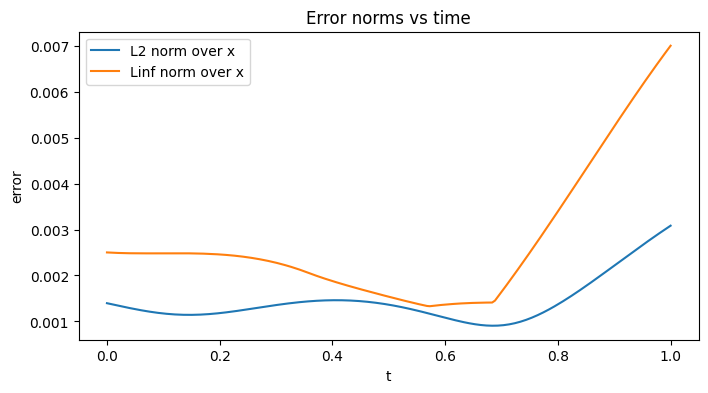

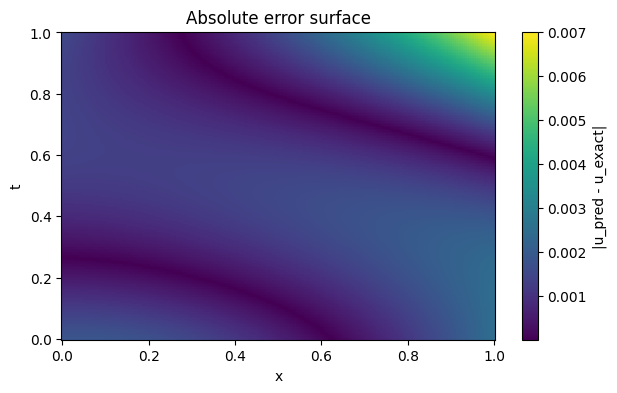

In [20]:
# compute errors over x for each t
abs_err = np.abs(U_pred_flat - U_exact)
L2_for_t = np.sqrt(np.mean(abs_err**2, axis=1))   # discrete L2 over x
Linf_for_t = np.max(abs_err, axis=1)

plt.figure(figsize=(8,4))
plt.plot(ts, L2_for_t, label='L2 norm over x')
plt.plot(ts, Linf_for_t, label='Linf norm over x')
plt.xlabel('t'); plt.ylabel('error'); plt.legend(); plt.title('Error norms vs time')
plt.show()

# absolute error surface
plt.figure(figsize=(7,4))
plt.pcolormesh(Xg, Tg, abs_err, shading='auto')
plt.colorbar(label='|u_pred - u_exact|')
plt.xlabel('x'); plt.ylabel('t'); plt.title('Absolute error surface')
plt.show()


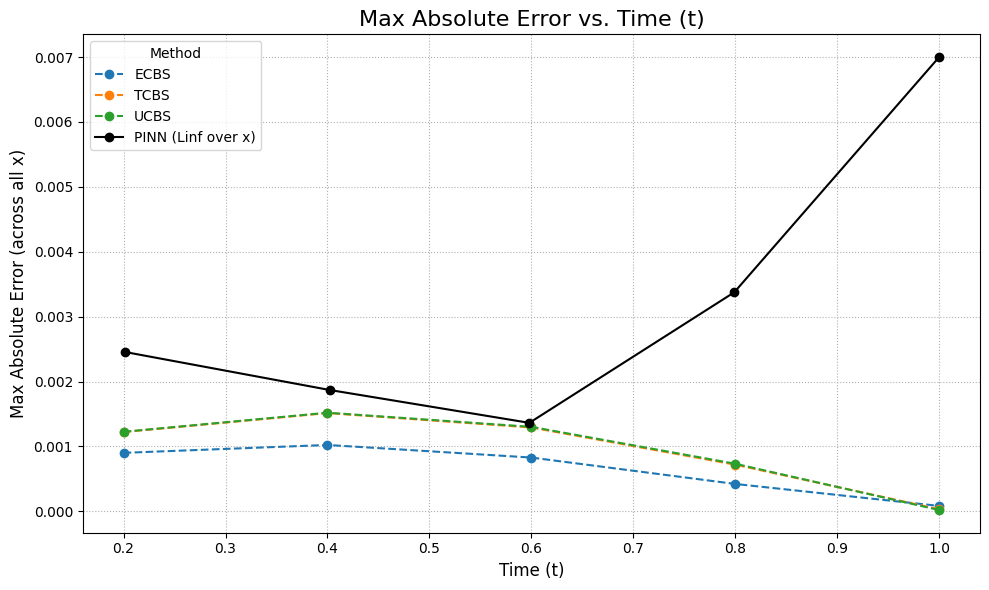

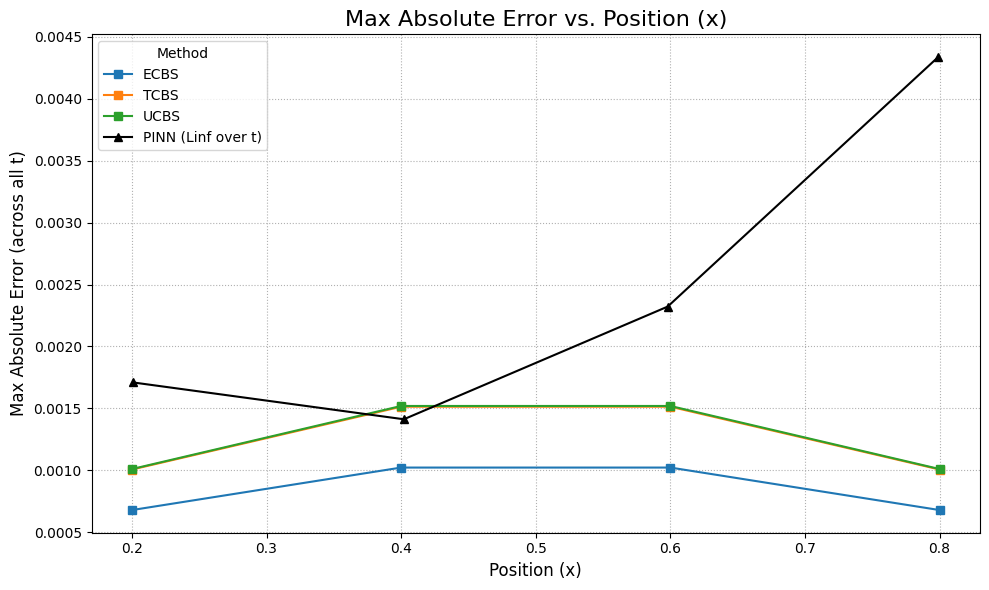

In [21]:

Linf_for_x = np.max(abs_err, axis=0)
# Linf_for_t

#data from reference paper
index = pd.MultiIndex.from_product(
    [[0.2, 0.4, 0.6, 0.8], ['UCBS', 'TCBS', 'ECBS']],
    names=['x', 'Method']
)

columns_t = [0.2, 0.4, 0.6, 0.8, 1.0]
columns_x = [0.2, 0.4, 0.6, 0.8]

data = [
    [8.323E-04, 1.011E-03, 8.581E-04, 4.745E-04, 1.991E-05], # x=0.2, UCBS
    [8.295E-04, 1.007E-03, 8.514E-04, 4.651E-04, 3.239E-05], # x=0.2, TCBS
    [6.068E-04, 6.800E-04, 5.476E-04, 2.746E-04, 6.339E-05], # x=0.2, ECBS
    [1.226E-03, 1.520E-03, 1.302E-03, 7.334E-04, 4.932E-06], # x=0.4, UCBS
    [1.222E-03, 1.514E-03, 1.292E-03, 7.194E-04, 2.342E-05], # x=0.4, TCBS
    [9.013E-04, 1.023E-03, 8.289E-04, 4.221E-04, 8.366E-05], # x=0.4, ECBS
    [1.226E-03, 1.520E-03, 1.302E-03, 7.334E-04, 4.932E-06], # x=0.6, UCBS
    [1.222E-03, 1.514E-03, 1.292E-03, 7.194E-04, 2.342E-05], # x=0.6, TCBS
    [9.013E-04, 1.023E-03, 8.289E-04, 4.221E-04, 8.366E-05], # x=0.6, ECBS
    [8.323E-04, 1.011E-03, 8.581E-04, 4.745E-04, 1.991E-05], # x=0.8, UCBS
    [8.295E-04, 1.007E-03, 8.514E-04, 4.651E-04, 3.239E-05], # x=0.8, TCBS
    [6.068E-04, 6.800E-04, 5.476E-04, 2.746E-04, 6.339E-05]  # x=0.8, ECBS
]

df = pd.DataFrame(data, index=index, columns=columns_t)
df.columns.name = 't'


max_vs_t = df.groupby('Method').max().T
max_vs_x = df.max(axis=1).unstack()


#Linf over x for t
fig1, ax1 = plt.subplots(figsize=(10, 6))
max_vs_t.plot(ax=ax1, marker='o', linestyle='--')

ax1.set_title('Max Absolute Error vs. Time (t)', fontsize=16)
ax1.set_xlabel('Time (t)', fontsize=12)
ax1.set_ylabel('Max Absolute Error (across all x)', fontsize=12)
ax1.grid(True, linestyle=':')

t_vals = np.array(ts)
sel_t_idx = [np.argmin(np.abs(t_vals - ct)) for ct in columns_t]
plot_t = t_vals[sel_t_idx]
plot_Linf_t = Linf_for_t[sel_t_idx]
ax1.plot(plot_t, plot_Linf_t, 'ko-', label='PINN (Linf over x)')

ax1.legend(title='Method', loc='best')
plt.tight_layout()
plt.show()

#Linf over t for x
fig2, ax2 = plt.subplots(figsize=(10, 6))
max_vs_x.plot(ax=ax2, marker='s', linestyle='-')

ax2.set_title('Max Absolute Error vs. Position (x)', fontsize=16)
ax2.set_xlabel('Position (x)', fontsize=12)
ax2.set_ylabel('Max Absolute Error (across all t)', fontsize=12)
ax2.grid(True, linestyle=':')


x_vals = np.array(xs)
sel_x_idx = [np.argmin(np.abs(x_vals - cx)) for cx in columns_x]
plot_x = x_vals[sel_x_idx]
plot_Linf_x = Linf_for_x[sel_x_idx]
ax2.plot(plot_x, plot_Linf_x, 'k^-', label='PINN (Linf over t)')

ax2.legend(title='Method', loc='best')
plt.tight_layout()
plt.show()


In [22]:
import gc
import pandas as pd

Ns = list(map(int, np.linspace(1000, 10000, 20)))
# Ns = [1000, 2000]
epochs_timing = 1000
Nb_timing = 200
Ni_timing = 200
lr_timing = 0.02 # test 

timings = []
final_losses = []
gpu = torch.cuda.is_available()

print("Warm-up run...")
_ = train_pinn(PINNNet(layers).to(device), epochs=50, Nf=500, Nb=100, Ni=100, lr=1e-3, print_every=1000)

for Nf in Ns:
    print(f"\nTiming experiment: Nf = {Nf}, epochs = {epochs_timing}")
    gc.collect()
    if gpu:
        torch.cuda.empty_cache()
        
    # new model init
    model_t = PINNNet(layers).to(device)
    t0 = time()
    hist_t = train_pinn(model_t, epochs=epochs_timing, Nf=Nf, Nb=Nb_timing, Ni=Ni_timing, lr=lr_timing, print_every=epochs_timing+1)
    t1 = time()
    wall = t1 - t0
    timings.append(wall)
    final_losses.append(hist_t['total'][-1] if len(hist_t['total'])>0 else None)
    print(f"Done: Nf={Nf}  time={wall:.2f}s  final_loss={final_losses[-1]:.3e}")

# summarize results in a dataframe and plot
df = pd.DataFrame({"Nf": Ns, "time_s": timings, "final_loss": final_losses})
print("\nResults:")
print(df)

# Plot timing vs Nf
plt.figure(figsize=(7,4))
plt.plot(df['Nf'], df['time_s'], marker='o')
plt.xlabel("Number of collocation points (Nf)")
plt.ylabel("Wall-clock time (s)")
plt.title(f"PINN training time (epochs={epochs_timing})")

#poly obf
coeffs = np.polyfit(df['Nf'], df['time_s'], 1)
fit_line = np.poly1d(coeffs)(df['Nf'])
plt.plot(df['Nf'], fit_line, linestyle='--', label=f"fit: {coeffs[0]:.4f} s/pt * N + {coeffs[1]:.2f}")
plt.legend()
plt.grid(True)
plt.show()

import os
fn = os.path.join(os.getcwd(), "run_results.csv")
df.to_csv(fn, index=False)
print(f"Saved results to {fn}")



Warm-up run...
Ep 1/50  total=1.891e-01  res=8.342e-02  bc=9.083e-02  ic=1.488e-02
Training time (s): 0.5572175979614258

Timing experiment: Nf = 1000, epochs = 1000
Ep 1/1000  total=2.954e-02  res=5.876e-03  bc=2.079e-02  ic=2.878e-03
Training time (s): 10.725938081741333
Done: Nf=1000  time=10.73s  final_loss=8.549e-05

Timing experiment: Nf = 1473, epochs = 1000
Ep 1/1000  total=5.253e-01  res=2.650e-01  bc=1.419e-01  ic=1.184e-01
Training time (s): 11.36944317817688
Done: Nf=1473  time=11.37s  final_loss=7.089e-05

Timing experiment: Nf = 1947, epochs = 1000
Ep 1/1000  total=1.709e-01  res=8.081e-02  bc=7.874e-02  ic=1.137e-02
Training time (s): 11.506801128387451
Done: Nf=1947  time=11.51s  final_loss=1.292e-05

Timing experiment: Nf = 2421, epochs = 1000
Ep 1/1000  total=3.794e-02  res=7.237e-03  bc=2.006e-02  ic=1.064e-02
Training time (s): 10.963608264923096
Done: Nf=2421  time=10.96s  final_loss=1.069e-04

Timing experiment: Nf = 2894, epochs = 1000
Ep 1/1000  total=1.779e-01 

KeyboardInterrupt: 